In [37]:
############################ PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations, product
import pyreadr
import seaborn as sns
import copy

import tensorflow as tf
import tensorflow_lattice as tfl
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding, Activation
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from keras.optimizers.legacy import Adam, Nadam, RMSprop
from keras.models import clone_model
import keras_tuner as kt
from keras import backend as K
from keras import regularizers
from keras.utils import plot_model
from keras.losses import Poisson, Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError

# import xgboost as xgb
from scipy.stats import uniform, randint
from pygam import PoissonGAM, GAM, s, f, l, te # s for spline, f for factor, l for linear, te for tensor product
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer
from interpret.glassbox import ExplainableBoostingRegressor
import joblib

import warnings
warnings.filterwarnings('ignore') # suprress warnings

In [38]:
#-------------------------- for reproducibility --------------------------
seed_value = 2000
keras.utils.set_random_seed(seed_value)
np.random.seed(seed_value)

In [39]:
#-------------------------- import data --------------------------
''' Belgian motor third-party liability dataset from the CAS collection '''
r_data = pyreadr.read_r("data/beMTPL97.rda")
data = r_data['beMTPL97']
data.head() # view data snapshot

,id,expo,claim,nclaims,amount,average,coverage,ageph,sex,bm,power,agec,fuel,use,fleet,postcode,long,lat
0,1,1.000000,1,1,1618.001036,1618.001036,TPL,50,male,5,77,12,gasoline,private,0,1000,4.355223,50.845386
1,2,1.000000,0,0,0.000000,NaN,TPL+,64,female,5,66,3,gasoline,private,0,1000,4.355223,50.845386
2,3,1.000000,0,0,0.000000,NaN,TPL,60,male,0,70,10,diesel,private,0,1000,4.355223,50.845386
3,4,1.000000,0,0,0.000000,NaN,TPL,77,male,0,57,15,gasoline,private,0,1000,4.355223,50.845386
4,5,0.046575,1,1,155.974606,155.974606,TPL,28,female,9,70,7,gasoline,private,0,1000,4.355223,50.845386


In [40]:
############################ DATA UNDERSTANDING & CLEANING ############################

#-------------------------- high-level checking --------------------------
print(data.shape) # number of rows and columns
print(data.info()) # check data type and missing values

(163212, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163212 entries, 0 to 163211
Data columns (total 18 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   id        163212 non-null  int32   
 1   expo      163212 non-null  float64 
 2   claim     163212 non-null  category
 3   nclaims   163212 non-null  int32   
 4   amount    163212 non-null  float64 
 5   average   18276 non-null   float64 
 6   coverage  163212 non-null  category
 7   ageph     163212 non-null  int32   
 8   sex       163212 non-null  category
 9   bm        163212 non-null  int32   
 10  power     163212 non-null  int32   
 11  agec      163212 non-null  int32   
 12  fuel      163212 non-null  category
 13  use       163212 non-null  category
 14  fleet     163212 non-null  category
 15  postcode  163212 non-null  int32   
 16  long      163212 non-null  float64 
 17  lat       163212 non-null  float64 
dtypes: category(6), float64(5), int32(7)
memory usage: 

In [41]:
#-------------------------- filter claim data --------------------------
claim = data.drop(columns = ["id","claim","amount","average","postcode"]).reset_index(drop = True) # filter positive claims and remove unnecessary columns
print(f"{claim.shape[0]} rows and {claim.shape[1]} columns")
claim.head()

163212 rows and 13 columns


,expo,nclaims,coverage,ageph,sex,bm,power,agec,fuel,use,fleet,long,lat
0,1.000000,1,TPL,50,male,5,77,12,gasoline,private,0,4.355223,50.845386
1,1.000000,0,TPL+,64,female,5,66,3,gasoline,private,0,4.355223,50.845386
2,1.000000,0,TPL,60,male,0,70,10,diesel,private,0,4.355223,50.845386
3,1.000000,0,TPL,77,male,0,57,15,gasoline,private,0,4.355223,50.845386
4,0.046575,1,TPL,28,female,9,70,7,gasoline,private,0,4.355223,50.845386


In [42]:
#-------------------------- descriptive statistics for numeric columns --------------------------
claim[["expo","nclaims","ageph","bm","power","agec","long","lat"]].describe()

,expo,nclaims,ageph,bm,power,agec,long,lat
count,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000
mean,0.889744,0.123857,47.000950,3.268246,56.002978,7.374923,4.407262,50.758422
std,0.244202,0.367471,14.831561,3.998171,19.024828,4.206447,0.751036,0.317856
min,0.002740,0.000000,18.000000,0.000000,10.000000,0.000000,2.577787,49.536246
25%,1.000000,0.000000,35.000000,0.000000,43.000000,4.000000,3.879313,50.516333
50%,1.000000,0.000000,46.000000,1.000000,53.000000,7.000000,4.387146,50.771932
75%,1.000000,0.000000,58.000000,6.000000,66.000000,10.000000,4.874195,50.994654
max,1.000000,5.000000,95.000000,22.000000,243.000000,48.000000,6.305543,51.449816


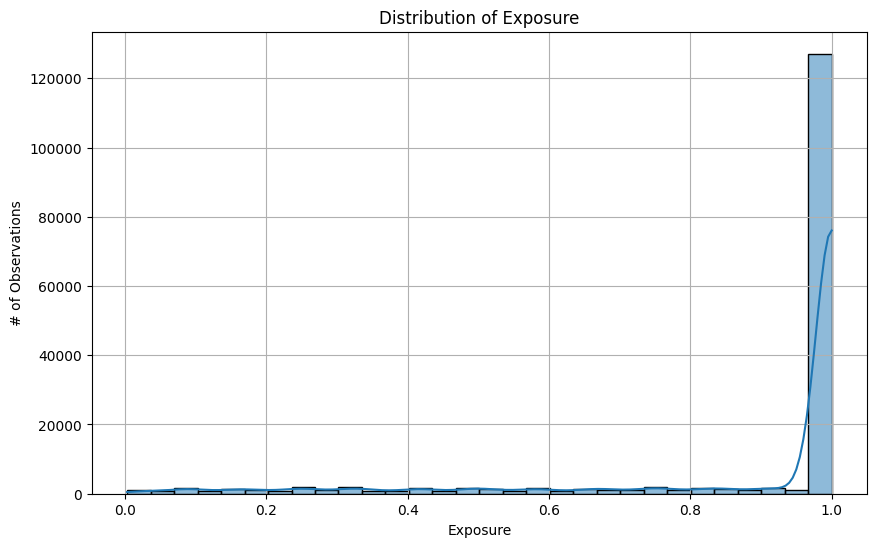

In [43]:
#-------------------------- distribution of claim amount --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.histplot(claim['expo'], bins = 30, kde = True) # draw the chart
plt.title('Distribution of Exposure')
plt.xlabel('Exposure')
plt.ylabel('# of Observations')
plt.grid(True)
plt.show()

In [44]:
### function to get the summary of number of instances per distinct category for categorical variable
def get_summary(data, column):
    summary = data[column].value_counts().reset_index()
    summary.columns = [column, 'Count']
    return summary

In [45]:
#-------------------------- check the distribution of categorical variables --------------------------
# get the categorical variables
cat_vars = ["coverage", "sex", "fuel", "use", "fleet"]
num_vars = ["ageph", "bm", "power", "agec", "long", "lat"] # numerical variables
all_vars = ["expo"] + cat_vars + num_vars

# get the distributions of categorical and target variables
summary_tables = {}
for column in ["nclaims"] + cat_vars:
    summary = get_summary(claim, column)
    summary_tables[column] = summary

# display the summary tables
for column, summary in summary_tables.items():
    print(f"{column} Summary:\n", summary, "\n")

nclaims Summary:
    nclaims   Count
0        0  144936
1        1   16539
2        2    1556
3        3     162
4        4      17
5        5       2 

coverage Summary:
   coverage  Count
0      TPL  95124
1     TPL+  45984
2    TPL++  22104 

sex Summary:
       sex   Count
0    male  120044
1  female   43168 

fuel Summary:
        fuel   Count
0  gasoline  112818
1    diesel   50394 

use Summary:
        use   Count
0  private  155334
1     work    7878 

fleet Summary:
   fleet   Count
0     0  158041
1     1    5171 



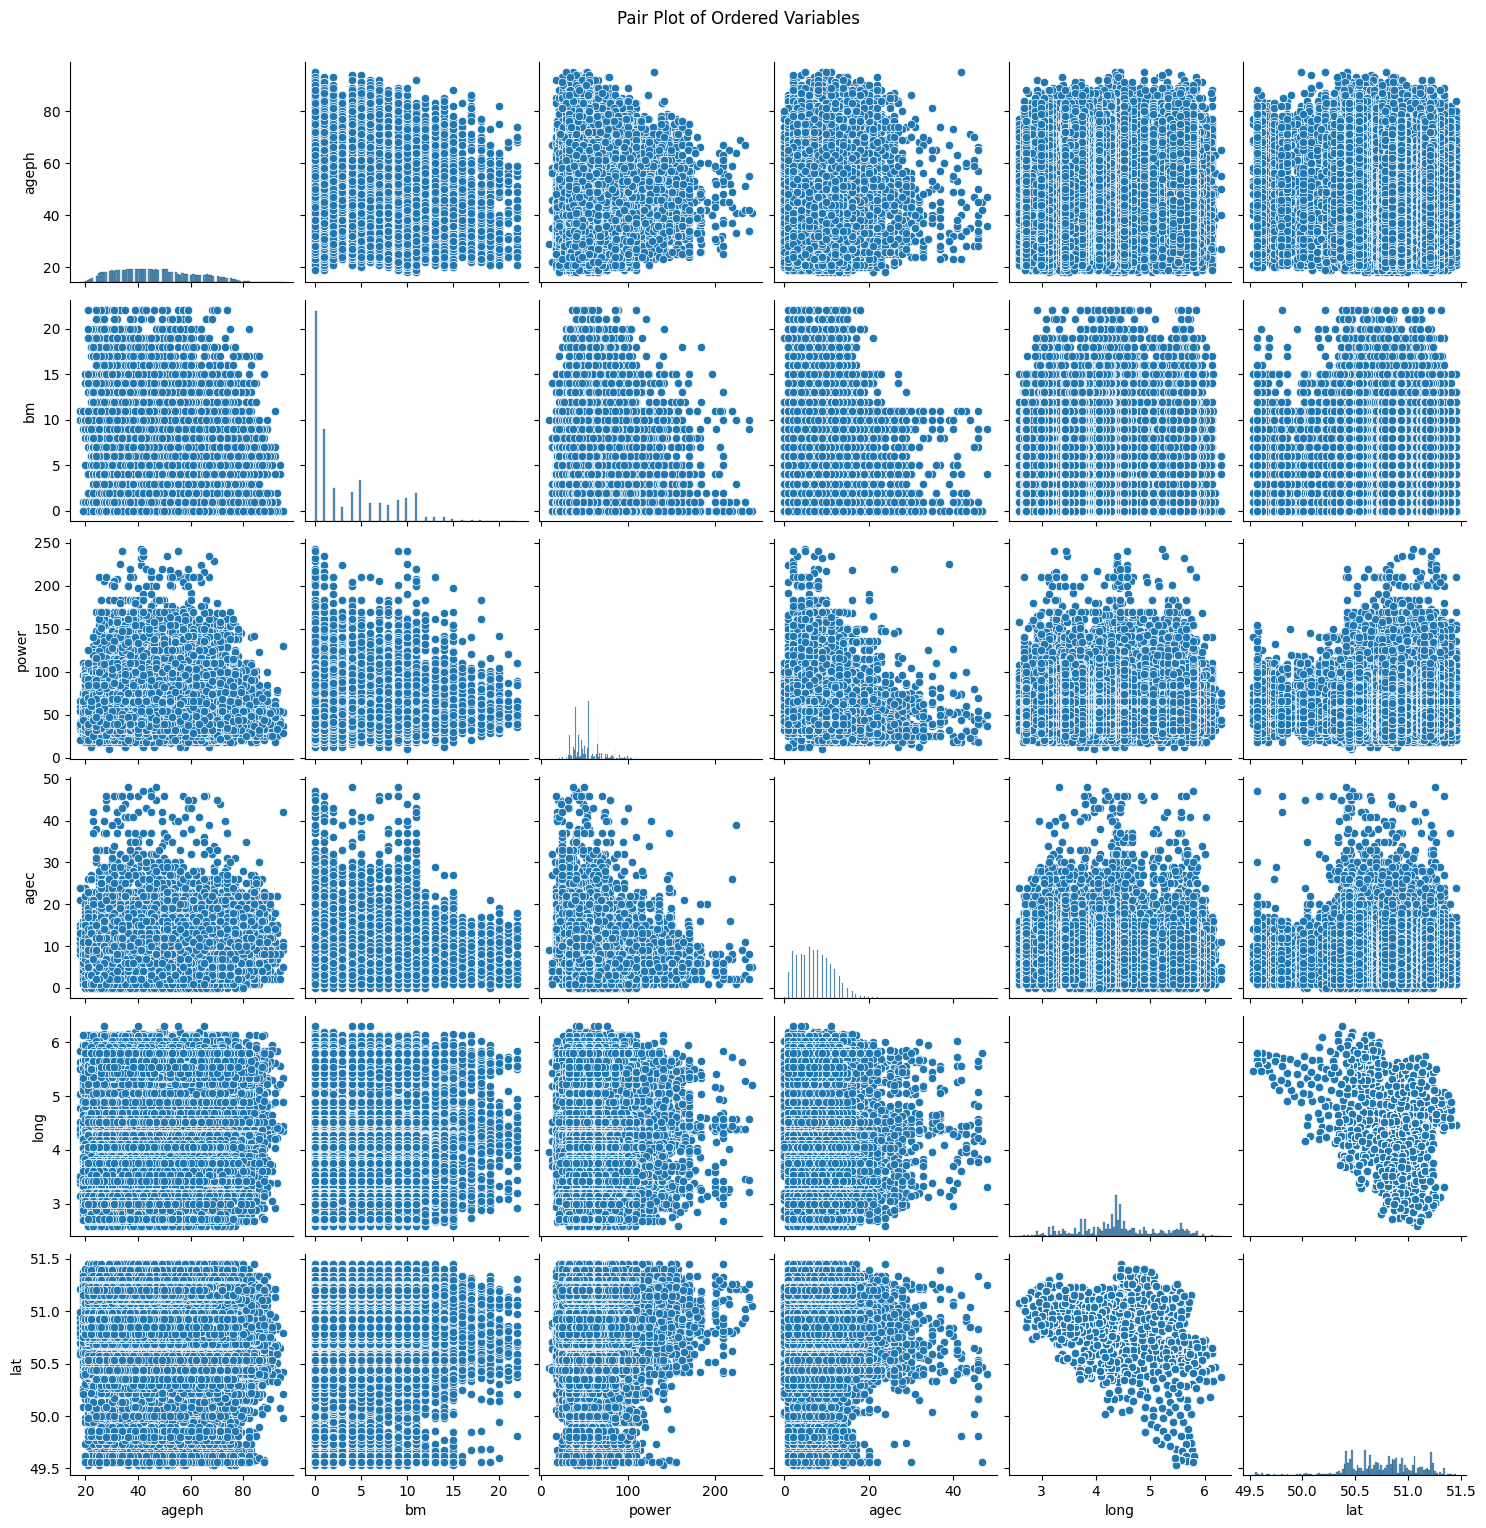

In [46]:
# -------------------------- check distribution of continuous and ordinal variables --------------------------
# Create pair plots for the specified variables
sns.pairplot(claim[num_vars])
plt.suptitle('Pair Plot of Ordered Variables', y = 1.02)
plt.show()

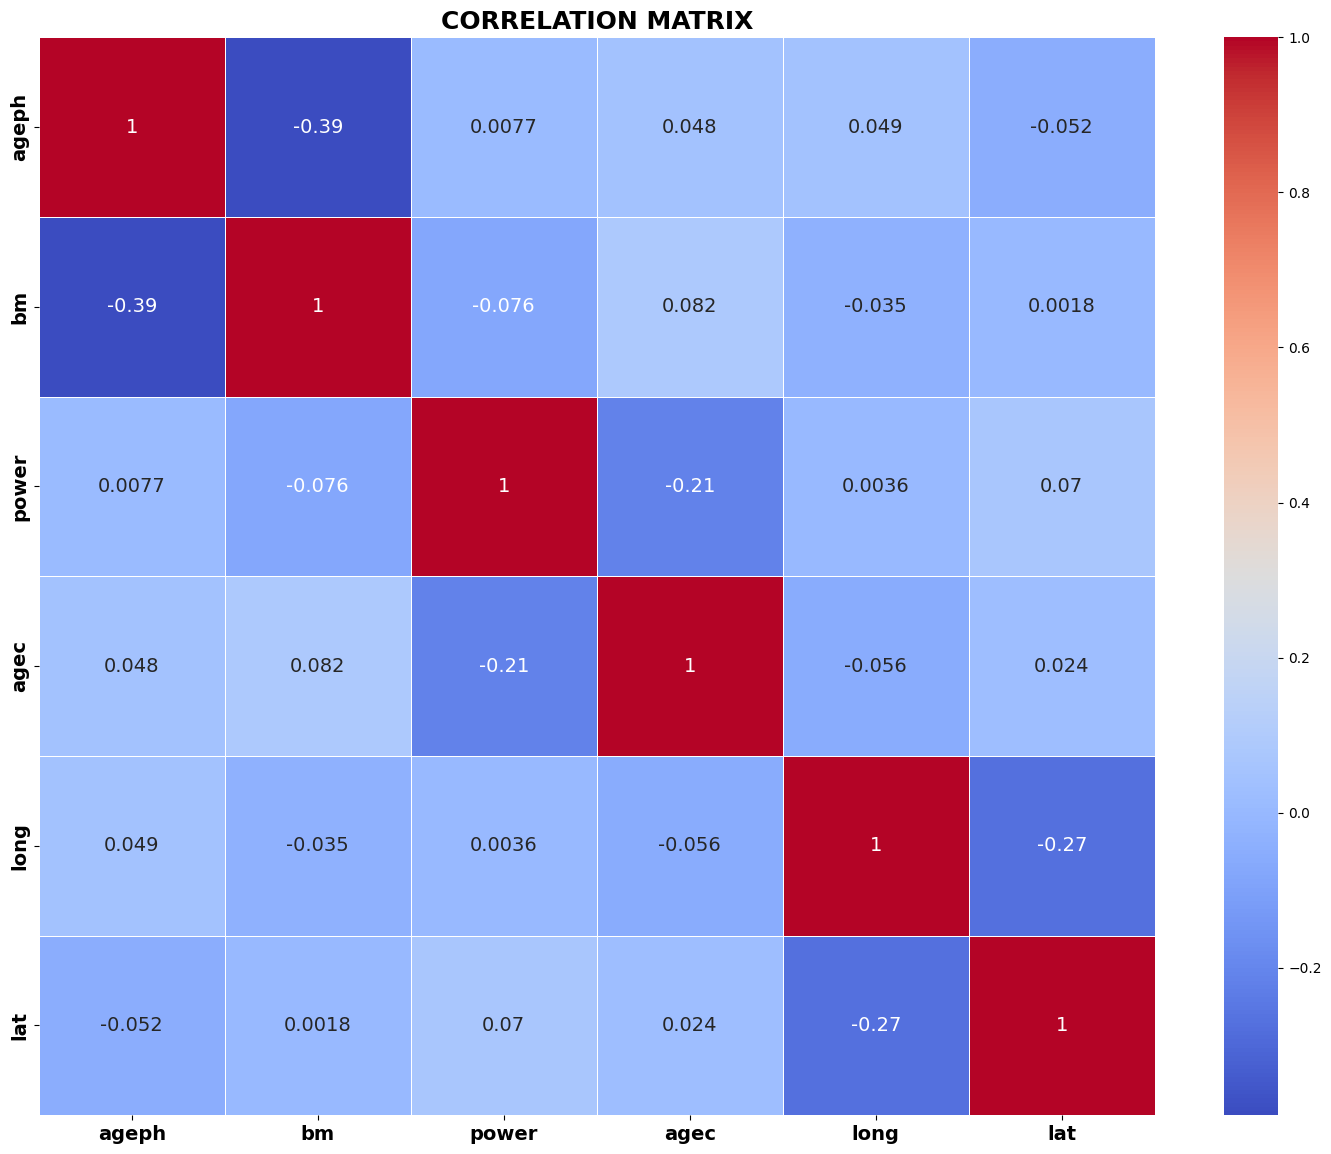

In [47]:
#-------------------------- check correlations of numeric variables --------------------------
correlation_matrix = claim[num_vars].corr() # correlation matrix

# plot the heatmap
plt.figure(figsize = (18, 14))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', linewidths = 0.5, annot_kws = {"size":14})
plt.title('CORRELATION MATRIX', fontsize = 18, fontweight = 'bold')
plt.xticks(fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 14, fontweight = 'bold')
plt.show()

In [48]:
#-------------------------- train-test split --------------------------
target_var = "nclaims"
X_main, X_test, y_main, y_test = train_test_split(
    claim[all_vars], claim[target_var], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [49]:
#-------------------------- variable encoding --------------------------
# define transformer
ct = make_column_transformer(
    ("passthrough", ["expo"]),
    (OrdinalEncoder(), cat_vars),
    remainder = StandardScaler(),
    verbose_feature_names_out = False
)

# fit & transform
train = ct.fit_transform(X_train)
val = ct.fit_transform(X_val)
test = ct.transform(X_test)
feature_names = ct.get_feature_names_out()  # get the columns' names
feature_names

array(['expo', 'coverage', 'sex', 'fuel', 'use', 'fleet', 'ageph', 'bm',
       'power', 'agec', 'long', 'lat'], dtype=object)

In [50]:
############################ NEURAL ADDITIVE MODEL ############################

# -------------------------- create custom layer and subnetwork --------------------------
# subnetwork for numerical variables
def create_subnet(num_layers, units_first_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for i in range(num_layers):
        num_units = units_first_layer - i*int(units_first_layer/num_layers)
        model.add(Dense(num_units, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(BatchNormalization(scale = False)) # for identifiability
    return model

# layer to add all subnets' outputs and a bias term
@keras.saving.register_keras_serializable()
class AddSubnetOutput(Layer):
    def __init__(self, activation = None, **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.bias = self.add_weight(
            shape = (1,), initializer = 'zeros', trainable = True, name = 'bias'
        )   
    def call(self, inputs):
        subnet_sum = K.sum(inputs, axis = -1, keepdims = True)
        output = subnet_sum + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

# helper function to add calibrator layer
def add_calibrate_layer(var, other_var, data, monotonicity_list, lattice_sizes, keypoints, cat_vars, all_vars, lattice_smooth_reg = [0,0]):
    if var in cat_vars:
        calibrator_layer = tfl.layers.CategoricalCalibration(
            num_buckets = np.unique(data[:,all_vars.index(var)]).size,
            output_min = 0,
            output_max = lattice_sizes[var] - 1,
            name = f"{var}_calibrator_pairwise_{var}_{other_var}"
        )
    else:
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(data[:,all_vars.index(var)].min(), data[:,all_vars.index(var)].max(), num = keypoints), # keypoints
            kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
            monotonicity = monotonicity_list[var] if var in monotonicity_list else "none", # monotonicity constraint
            output_min = 0,
            output_max = lattice_sizes[var] - 1,
            name = f"{var}_calibrator_pairwise_{var}_{other_var}"
            )
    return calibrator_layer

In [51]:
# -------------------------- custom constraint--------------------------
# function to add smoothness penalty
def make_smoothness_penalty(var, data, model, lambd_smooth, grid_length, imp_vars, all_vars):
    # Create input grid as TensorFlow tensors
    grid_min = tf.constant(data[:,all_vars.index(var)].min(), dtype = tf.float32)
    grid_max = tf.constant(data[:,all_vars.index(var)].max(), dtype = tf.float32)
    grid = tf.linspace(grid_min, grid_max, grid_length)
    grid = tf.reshape(grid, (-1, 1))  # Ensure grid is a column vector

    # Prepare inputs for the model
    grid_inputs = []
    for feature in imp_vars:
        if feature == var:
            grid_inputs.append(grid)
        else:
            # Use zeros_like to match the shape of grid
            grid_inputs.append(tf.zeros_like(grid))

    # Define a zero-argument function to compute the penalty
    def smoothness_penalty():
        # Get the prediction
        f = model(grid_inputs)[:, imp_vars.index(var) - 1]
        f = tf.reshape(f, (-1,))  # Flatten to 1D tensor for slicing

        # Calculate the second derivative using finite differences
        h = (grid_max - grid_min) / (grid_length - 1)
        h_squared = h ** 2
        f_plus = f[2:]      # f(x + h)
        f_minus = f[:-2]    # f(x - h)
        f_current = f[1:-1] # f(x)

        # Second derivative approximation
        second_derivative = (f_plus + f_minus - 2 * f_current) / h_squared

        # Compute the penalty
        penalty = lambd_smooth * K.mean(tf.abs(second_derivative))
        return penalty
    
    return smoothness_penalty



# function to add monotonicity penalty
def make_monotonicity_penalty(var, data, model, lambd_monotonic, grid_length, imp_vars, all_vars, monotonic_increasing = True):
    # Create input grid as TensorFlow tensors
    grid_min = tf.constant(data[:,all_vars.index(var)].min(), dtype = tf.float32)
    grid_max = tf.constant(data[:,all_vars.index(var)].max(), dtype = tf.float32)
    grid = tf.linspace(grid_min, grid_max, grid_length)
    grid = tf.reshape(grid, (-1, 1))  # Ensure grid is a column vector

    # Prepare inputs for the model
    grid_inputs = []
    for feature in imp_vars:
        if feature == var:
            grid_inputs.append(grid)
        else:
            grid_inputs.append(tf.zeros_like(grid))

    def monotonicity_penalty():
        # Get the prediction
        f = model(grid_inputs)[:, imp_vars.index(var) - 1]
        f = tf.reshape(f, (-1,))  # Flatten to 1D tensor for slicing

        # Finite difference step size
        h = (grid_max - grid_min) / (grid_length - 1)

        # Compute first derivative approximations: f'(x) ~ (f(x+h) - f(x)) / h
        f_next = f[1:]
        f_current = f[:-1]
        first_derivative = (f_next - f_current) / h

        # Depending on the monotonicity constraint, define the violation
        # If monotonic_increasing = True, penalize negative slopes: slope < 0
        # If monotonic_increasing = False, penalize positive slopes: slope > 0
        if monotonic_increasing:
            violations = tf.nn.relu(-first_derivative)
        else:
            violations = tf.nn.relu(first_derivative)

        penalty = lambd_monotonic * K.mean(violations)
        return penalty

    return monotonicity_penalty

In [52]:
#-------------------------- data preparation --------------------------
imp_vars = ["ageph", "bm", "power", "lat", "long", "fuel", "agec"]
X_train_split = []
X_val_split = []
X_test_split = []
for var in ["expo"] + imp_vars:
    X_train_split.append(train[:, all_vars.index(var)])
    X_val_split.append(val[:, all_vars.index(var)])
    X_test_split.append(test[:, all_vars.index(var)])

In [53]:
# -------------------------- define model architecture --------------------------
def build_NAM(hp):

    # -------------------- hyperpameters --------------------
    smooth_vars = ["ageph","bm","power","lat","long","agec"]
    interactions = [("long","agec"),("power","long"),("fuel","agec"),("lat","long"),("ageph","agec")]
    inputs = []  # input layers
    sub_outputs = [] # subnet output
    lattice_sizes = {} # number of vertices for each variable's lattice
    monotonicity = {"bm": "increasing"} # either increasing, decreasing, or none
    grid_length = 1000 # for using finite differences with smoothness constraint
    activation = "leaky_relu"

    # # hypeparameters for tuning
    # num_neurons_main = hp.Int('num_neurons_main', 20, 80, step = 20) # number of neurons for main effects' subnets' hidden layers
    # num_layers_main = hp.Int('num_layers_main', 2, 5) # number of hidden layers for main effects' subnets
    # num_neurons_interaction = hp.Int('num_neurons_int', 20, 140, step = 20) # number of neurons for interaction effects' subnets' hidden layers
    # num_layers_interaction = hp.Int('num_layers_int', 2, 10, step = 2) # number of hidden layers for interaction effects' subnets
    # num_keypoints = hp.Int('num_keypoints', 20, 60, step = 10) # number of key points for lattice calibrator
    # num_vertices = hp.Int('num_vertices', 2, 20, step = 4) # number of vertices for lattice layer
    # lambd_mc = hp.Float('lambd_mc', min_value = 1e-5, max_value = 1e-2, sampling = 'log') # weight for marginal clarity constraint in objective function
    # lambd_smooth = hp.Float('lambd_smoothness', min_value = 1e-5, max_value = 1e-1, sampling = 'log') # weight for smoothness constraint in objective function

    # hyperparameters
    num_neurons_main = 20
    num_layers_main = 5
    num_neurons_interaction = 20
    num_layers_interaction = 10
    num_keypoints = 50
    num_vertices = 18
    lambd_mc = 0.0004661941083582669
    lambd_smooth = 0.021221642702824103
    lambd_monotonic = hp.Float('lambd_monotonic', min_value = 1e-5, max_value = 1e-2, sampling = 'log')


    # add lattice size
    for var in imp_vars:
        if var in cat_vars:
            lattice_sizes[var] = X_train[var].nunique()
        else:
            lattice_sizes[var] = num_vertices


    # -------------------- main effect --------------------
    for name in ["expo"] + imp_vars:
        # input layer
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)

        # subnetwork
        if name == "expo": # Direct use without a subnet
            exposure_input = input_layer
        elif name in cat_vars: # categorical variables will be one-hot encoded
            embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                    output_dim = 1, 
                                    name = f"{name}_embed")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
            sub_outputs.append(mean_layer)
        # elif name in monotonicity: # variables with monotonicity constraint
        #     calibrator_layer = tfl.layers.PWLCalibration(
        #         input_keypoints =  np.linspace(train[:,all_vars.index(name)].min(), train[:,all_vars.index(name)].max(), num = num_keypoints), # keypoints
        #         monotonicity = monotonicity[name], # monotonicity constraint
        #         name = f"{name}_pwlcalibrator"
        #     )(input_layer)
        #     mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
        #     sub_outputs.append(mean_layer)
        else: # numeric variables
            subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)


    # -------------------- pairwise interaction effect --------------------
    for (var1, var2) in interactions:
        var1_input = inputs[imp_vars.index(var1) + 1]
        var2_input = inputs[imp_vars.index(var2) + 1]

        if any(var in monotonicity for var in [var1, var2]):
            lattice_inputs = []

            # calibrator layer
            calibrator_var1 = add_calibrate_layer(var1, var2, train, monotonicity, lattice_sizes, num_keypoints, cat_vars, all_vars)
            calibrator_var2 = add_calibrate_layer(var2, var1, train, monotonicity, lattice_sizes, num_keypoints, cat_vars, all_vars)
            calibrator_layer_var1 = calibrator_var1(var1_input)
            calibrator_layer_var2 = calibrator_var2(var2_input)
            
            # lattice layer
            lattice_inputs.append(calibrator_layer_var1)
            lattice_inputs.append(calibrator_layer_var2)
            lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes[var1], lattice_sizes[var2]], 
                                                monotonicities = ["increasing" if var1 in monotonicity else 'none',
                                                                "increasing" if var2 in monotonicity else 'none'],
                                                name = f"{var1}_{var2}_lattice")(lattice_inputs)
            pairwise_output = BatchNormalization(scale = False, name = f"{var1}_{var2}_mean")(lattice_layer)
            sub_outputs.append(pairwise_output)

        else: # if no monotonicity constraint is required, create a normal subnetwork
            pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
            pairwise_subnet = create_subnet(num_layers_interaction, 
                                            num_neurons_interaction, 
                                            activation, 
                                            f"{var1}_{var2}_subnetwork")
            pairwise_dense = pairwise_subnet(pairwise_input_layer)
            sub_outputs.append(pairwise_dense)
        

    # -------------------- combine main and interaction effects --------------------
    # combine subnets' outputs
    main_subnets = Concatenate(name = "subnet_output")(sub_outputs)
    sum_output = AddSubnetOutput(activation = 'exponential',
                                    name = "sum_output")(main_subnets)
    final_output = Multiply(name = "final_output")([exposure_input, sum_output])
    model = Model(inputs = inputs, outputs = final_output)


    #-------------------------- add smoothness penalty --------------------------
    subnet_model = Model(inputs = model.inputs, outputs = main_subnets)
    for var in smooth_vars:
        penalty_function = make_smoothness_penalty(var, train, subnet_model, lambd_smooth, grid_length, ["expo"] + imp_vars, all_vars)
        model.add_loss(penalty_function)


    #-------------------------- add monotonicity penalty --------------------------
    for var, direction in monotonicity.items():
        monotonic_increasing = (direction == 'increasing')
        penalty_function = make_monotonicity_penalty(var, train, subnet_model, lambd_monotonic, grid_length, ["expo"] + imp_vars, all_vars, monotonic_increasing)
        model.add_loss(penalty_function)


    #-------------------------- add marginal clarity constraint --------------------------
    for i in range(len(interactions)):
        penalty = 0
        var1 = interactions[i][0]
        var2 = interactions[i][1]
        subnet_output = model.get_layer("subnet_output").output
        main_output_var1 = subnet_output[imp_vars.index(var1)]
        main_output_var2 = subnet_output[imp_vars.index(var2)]
        interaction_output = subnet_output[len(imp_vars) + i]
        penalty = lambd_mc * (
            K.abs(K.mean(main_output_var1 * interaction_output)) +
            K.abs(K.mean(main_output_var2 * interaction_output))
        )
        # Add the penalty to the model's total loss
        model.add_loss(penalty)


    #-------------------------- compile and return the model --------------------------
    model.compile(optimizer = "rmsprop", loss = "poisson", 
                    metrics = ["poisson", RootMeanSquaredError(), MeanAbsoluteError()])

    return model

In [54]:
# -------------------------- hyperparameters of final model --------------------------
# hyperparameter tuning
tuner_NAM = kt.tuners.BayesianOptimization(
    build_NAM,
    objective = kt.Objective('val_poisson', direction = 'min'),
    max_trials = 5,
    directory = "hyperparameter_beMTPL97_NAM_monot",
    seed = 0 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 50, restore_best_weights = True)

# search for the best model
tuner_NAM.search(X_train_split, y_train,
            epochs = 5_000,
            batch_size = 10_000,
            validation_data = (X_val_split, y_val),
            callbacks = [es])

# get the best model
model_nam = tuner_NAM.get_best_models()[0]
tuner_NAM.results_summary(1)

Trial 5 Complete [00h 02m 56s]
val_poisson: 0.3693574070930481

Best val_poisson So Far: 0.36926403641700745
Total elapsed time: 00h 14m 12s
Results summary
Results in hyperparameter_beMTPL97_NAM_monot/untitled_project
Showing 1 best trials
Objective(name="val_poisson", direction="min")

Trial 0 summary
Hyperparameters:
lambd_monotonic: 0.005325413061309015
Score: 0.36926403641700745


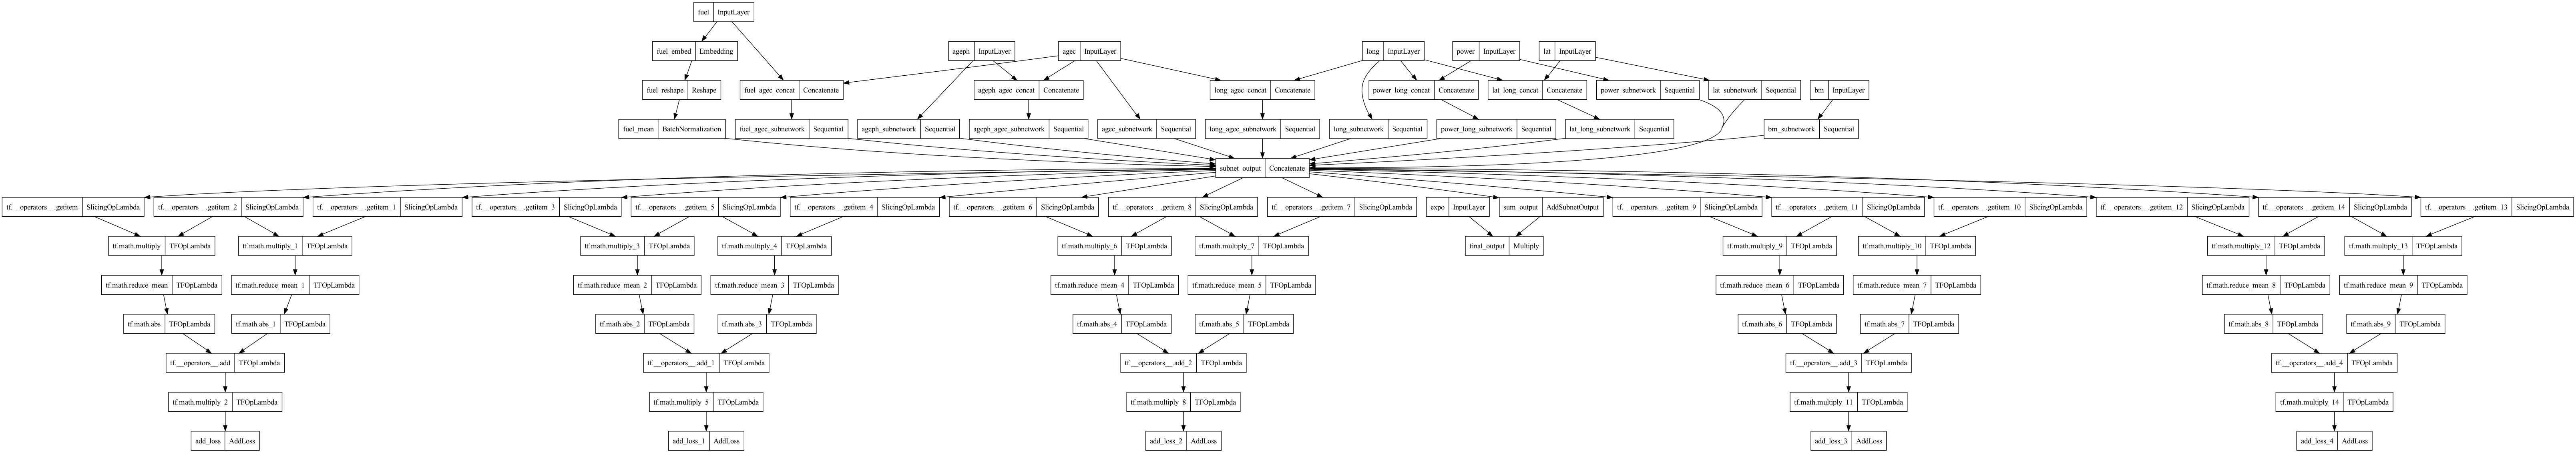

In [55]:
# plot themodel
plot_model(model_nam)

In [56]:
#-------------------------- evaluate predictive performance --------------------------
_, nam_nll, nam_rmse, nam_mae = model_nam.evaluate(X_test_split, y_test, batch_size = 5_000)
print(f"Poisson loss on test set: {nam_nll}")
print(f"RMSE on test set: {nam_rmse}")
print(f"MAE on test set: {nam_mae}")

7/7 [==============================] - 12s 27ms/step - loss: 0.3813 - poisson: 0.3791 - root_mean_squared_error: 0.3680 - mean_absolute_error: 0.2139
Poisson loss on test set: 0.3791385293006897
RMSE on test set: 0.367999792098999
MAE on test set: 0.21387140452861786


1/1 [==============================] - 1s 940ms/step


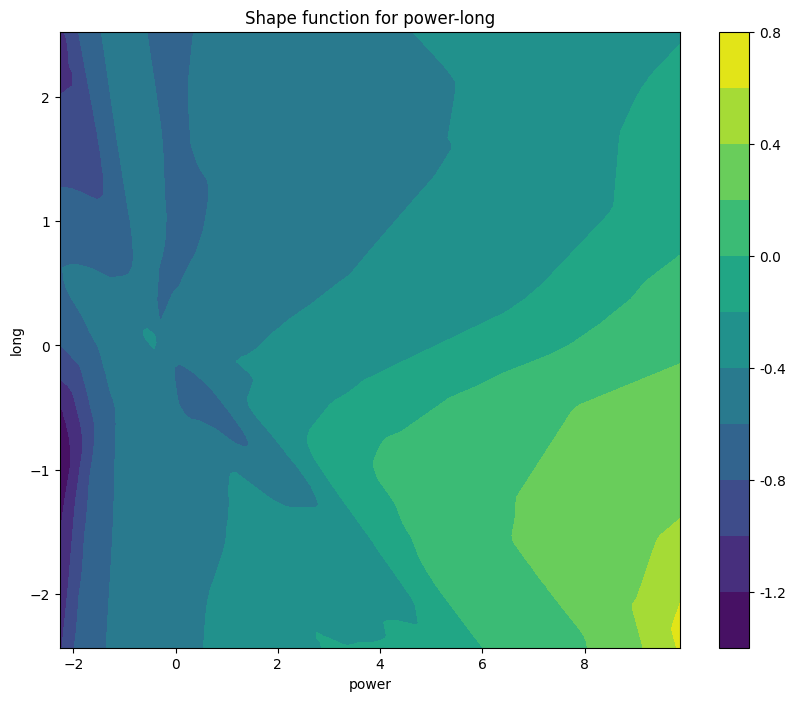

In [57]:
# -------------------------- Create the Pairwise Only Model --------------------------
interactions = [("long","agec"),("power","long"),("fuel","agec"),("lat","long"),("ageph","agec")]
pairwise_effect = ("power","long")  # the pairwise effect we want to view
pairwise_index = interactions.index(pairwise_effect)
subnet_output_layer = model_nam.get_layer("subnet_output")
subnet_model = Model(inputs = model_nam.inputs, outputs = subnet_output_layer.output)


# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 100
if pairwise_effect[0] in cat_vars:
    var1_values = np.unique(X_train_split[imp_vars.index(pairwise_effect[0]) + 1])
else:
    var1_values = np.linspace(np.min(X_train_split[imp_vars.index(pairwise_effect[0]) + 1]), 
                              np.max(X_train_split[imp_vars.index(pairwise_effect[0]) + 1]), 
                              grid_length)
if pairwise_effect[1] in cat_vars:
    var2_values = np.unique(X_train_split[imp_vars.index(pairwise_effect[1]) + 1])
else:
    var2_values = np.linspace(np.min(X_train_split[imp_vars.index(pairwise_effect[1]) + 1]), 
                              np.max(X_train_split[imp_vars.index(pairwise_effect[1]) + 1]), 
                              grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
for var in ["expo"] + imp_vars:
    if var == pairwise_effect[0]:
        grid_inputs.append(grid_flat_var1)
    elif var == pairwise_effect[1]:
        grid_inputs.append(grid_flat_var2)
    else:
        grid_inputs.append(np.zeros_like(grid_flat_var1))


# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
# main1_predictions = subnet_model.predict(grid_inputs, batch_size = 10_000)[:,imp_vars.index(pairwise_effect[0])]
# main2_predictions = subnet_model.predict(grid_inputs, batch_size = 10_000)[:,imp_vars.index(pairwise_effect[1])]
pairwise_predictions = subnet_model.predict(grid_inputs, batch_size = 10_000)[:,len(imp_vars) + pairwise_index]
# total_predictions = main1_predictions + main2_predictions + pairwise_predictions

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10, cmap = "viridis")
plt.colorbar(contour, format="%.1f")
plt.title(f'Shape function for {pairwise_effect[0]}-{pairwise_effect[1]}')
plt.xlabel(f"{interactions[pairwise_index][0]}")
plt.ylabel(f"{interactions[pairwise_index][1]}")

# plt.rcParams["figure.figsize"] = (4, 4) # (for square figures)
# plt.rcParams["figure.dpi"] = 350
# plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False

plt.show()

1/1 [==============================] - 0s 29ms/step


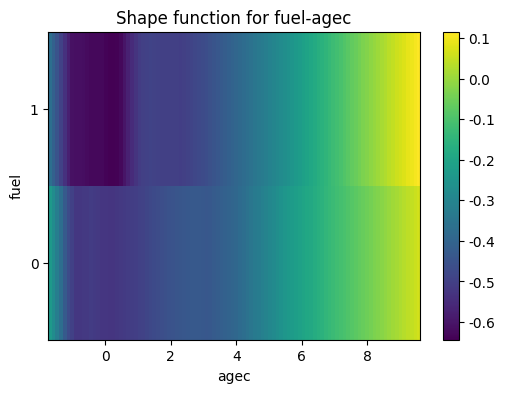

In [58]:
# -------------------------- Create the Pairwise Only Model --------------------------
interactions = [("long","agec"),("power","long"),("fuel","agec"),("lat","long"),("ageph","agec")]
pairwise_effect = ("fuel", "agec")  # the pairwise effect we want to view
pairwise_index = interactions.index(pairwise_effect)
subnet_output_layer = model_nam.get_layer("subnet_output")
subnet_model = Model(inputs=model_nam.inputs, outputs=subnet_output_layer.output)

# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values for `agec`
grid_length = 100
var2_values = np.linspace(np.min(X_train_split[imp_vars.index(pairwise_effect[1]) + 1]), 
                          np.max(X_train_split[imp_vars.index(pairwise_effect[1]) + 1]), 
                          grid_length)

# Generate inputs for `fuel = 0` and `fuel = 1`
grid_inputs_0 = []
grid_inputs_1 = []
for var in ["expo"] + imp_vars:
    if var == pairwise_effect[0]:  # fuel
        grid_inputs_0.append(np.zeros_like(var2_values))  # fuel = 0
        grid_inputs_1.append(np.ones_like(var2_values))   # fuel = 1
    elif var == pairwise_effect[1]:  # agec
        grid_inputs_0.append(var2_values)
        grid_inputs_1.append(var2_values)
    else:
        grid_inputs_0.append(np.zeros_like(var2_values))
        grid_inputs_1.append(np.zeros_like(var2_values))

# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect for `fuel = 0` and `fuel = 1`
pairwise_predictions_0 = subnet_model.predict(grid_inputs_0, batch_size=10_000)[:, len(imp_vars) + pairwise_index]
pairwise_predictions_1 = subnet_model.predict(grid_inputs_1, batch_size=10_000)[:, len(imp_vars) + pairwise_index]

# Combine predictions into a 2-row heatmap format (fuel = 0 and fuel = 1)
heatmap_values = np.vstack([pairwise_predictions_0, pairwise_predictions_1])

# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize=(6, 4))
contour = plt.imshow(
    heatmap_values,
    aspect='auto',
    cmap='viridis',
    extent=[var2_values.min(), var2_values.max(), -0.5, 1.5],
    interpolation='none'  # Prevents grid lines due to interpolation
)
plt.colorbar(contour, format="%.1f")
plt.yticks([0, 1], ['0', '1'])
plt.title(f'Shape function for {pairwise_effect[0]}-{pairwise_effect[1]}')
plt.xlabel("agec")
plt.ylabel("fuel")

# Remove grid lines but keep axis labels
plt.grid(False)


# plt.rcParams["figure.figsize"] = (4, 4)  # For square figures
# plt.rcParams["figure.dpi"] = 350
# plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False

plt.show()


32/32 [==============================] - 0s 3ms/step


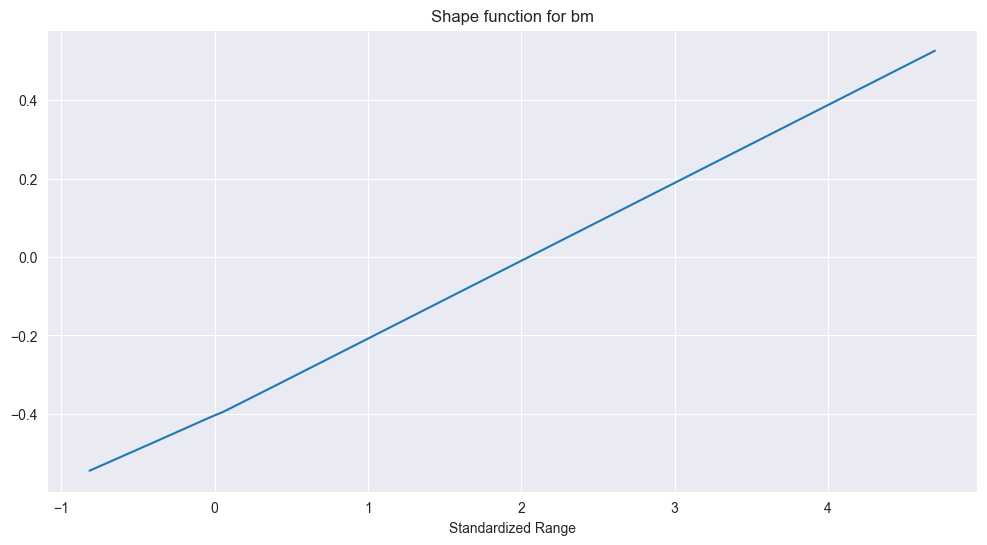

In [62]:
#-------------------------- view the shape function --------------------------
# create a grid
var_name = "bm"
var_index = imp_vars.index(var_name)
grid_length = 1000
grid_inputs = []
grid = np.linspace(np.min(X_train_split[imp_vars.index(var_name) + 1]), 
                   np.max(X_train_split[imp_vars.index(var_name) + 1]), 
                   grid_length)
for var in ["expo"] + imp_vars:
    if var == var_name:
        grid_inputs.append(grid)
    else:
        grid_inputs.append(np.zeros_like(grid))

# get the prediction
subnet_output = subnet_model.predict(grid_inputs)

# create the plot
plt.figure(figsize = (12, 6))
sns.lineplot(x = grid, y = subnet_output[:,var_index])
plt.xlabel(f"Standardized Range")
# plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)

# plt.rcParams["figure.figsize"] = (4, 4) # (for square figures)
# plt.rcParams["figure.dpi"] = 350
# plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False

plt.show()

1/1 [==============================] - 0s 49ms/step


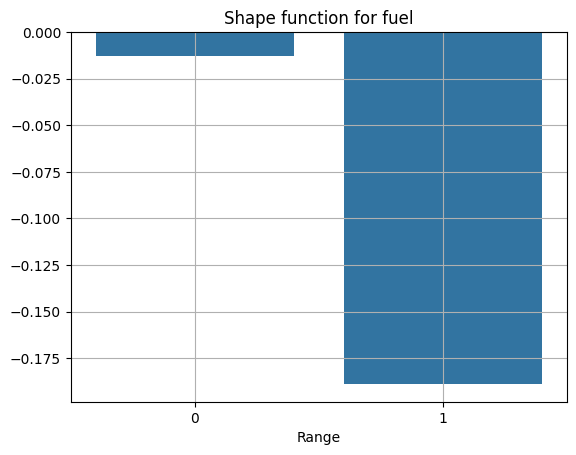

In [60]:
# -------------------------- View the Shape Function for Categorical Variable --------------------------
# Define the variable name and index
var_name = "fuel"
var_index = imp_vars.index(var_name)

# Prepare inputs for categorical values 0 and 1
grid_inputs_0 = []
grid_inputs_1 = []
for var in ["expo"] + imp_vars:
    if var == var_name:
        grid_inputs_0.append(np.zeros(1))  # fuel = 0
        grid_inputs_1.append(np.ones(1))   # fuel = 1
    else:
        grid_inputs_0.append(np.zeros(1))
        grid_inputs_1.append(np.zeros(1))

# Get predictions for fuel = 0 and fuel = 1
subnet_output_0 = subnet_model.predict(grid_inputs_0)
subnet_output_1 = subnet_model.predict(grid_inputs_1)

# Extract the subnetwork output for fuel
output_values = [subnet_output_0[0, var_index], subnet_output_1[0, var_index]]

# Plot the shape function
sns.barplot(x=[0, 1], y=output_values)
plt.xlabel(f"Range")
# plt.ylabel("Subnetwork Output")
plt.title(f"Shape function for {var_name}")
plt.grid(True)

# # Plot settings
# plt.rcParams["figure.figsize"] = (4, 4)  # For square figures
# plt.rcParams["figure.dpi"] = 350
# plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False

plt.show()


20/20 [==============================] - 1s 15ms/step


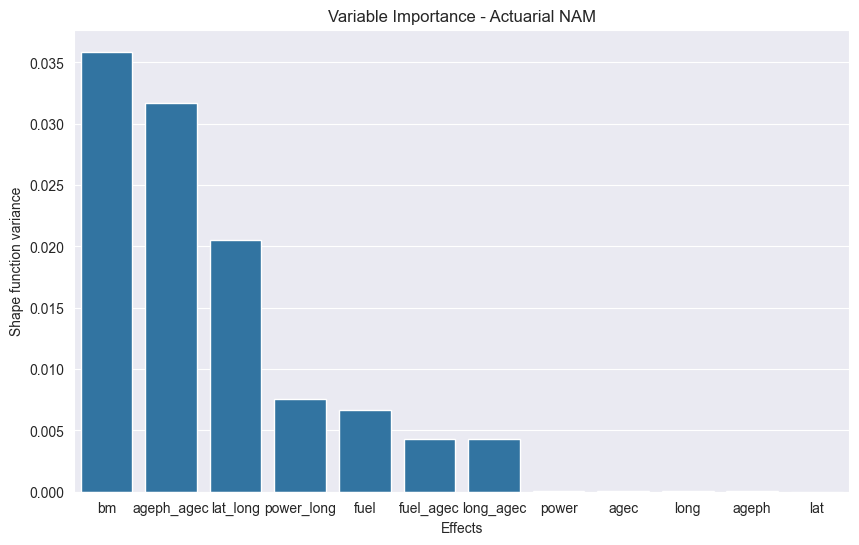

In [61]:
# -------------------------- quantify variable importance --------------------------
subnet_layer = model_nam.get_layer("subnet_output")
subnet_output_model = Model(inputs = model_nam.inputs, 
                            outputs = subnet_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_split, batch_size = 5_000)
# subnet_weights = model_nam.get_layer("final_output").get_weights()[0]


# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    # subnet_variance.append(np.var(subnet_output_values[:, i])*subnet_weights[i][0]**2)
    subnet_variance.append(np.var(subnet_output_values[:, i]))

# Define covariates
covariates = [name for name in imp_vars]
for i in range(len(interactions)):
    covariates.append(f"{interactions[i][0]}_{interactions[i][1]}")


# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.set_style("darkgrid")
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Variable Importance - Actuarial NAM")
plt.xlabel("Effects")
plt.ylabel("Shape function variance")

# plt.rcParams["figure.figsize"] = (12.0, 4.0)
# plt.rcParams["figure.dpi"] = 350
# plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False

plt.show()